In [2]:
from MCEq.core import config, MCEqRun
import crflux.models as crf
# matplotlib used plotting. Not required to run the code.
import matplotlib.pyplot as plt
import numpy as np



# config.e_max = 1000000000.0
# config.e_min = 0.05

from MCEq.core import MCEqRun


# Initalize MCEq by creating the user interface object MCEqRun
mceq = MCEqRun(

    # High-energy hadronic interaction model
    interaction_model='SIBYLL23C',

    # cosmic ray flux at the top of the atmosphere
    primary_model = (crf.HillasGaisser2012, 'H3a'),

    # zenith angle
    theta_deg = 0.
)

# Solve the equation system
mceq.solve()

# Obtain the result
# Multiply fluxes be E**mag to resolve the features of the steep spectrum
mag = 0
# muon_flux = (mceq.get_solution('mu+', mag) +
#              mceq.get_solution('mu-', mag))
# numu_flux = (mceq.get_solution('numu', mag) +
#              mceq.get_solution('antinumu', mag))
# nue_flux = (mceq.get_solution('nue', mag) +
#             mceq.get_solution('antinue', mag))

proton_flux = mceq.get_solution('p+', mag)
neutron_flux = mceq.get_solution('n0', mag)

# mceq.pman.print_particle_tables(0)


MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H3a


In [3]:
import numpy as np
import matplotlib.pyplot as plt

def k2p(k, mass=938.27e-3):
    return np.sqrt(k**2+2*k*mass)

def p2k(p, mass=938.27e-3):
    return np.sqrt(p**2+mass**2) - mass

def load_cry(filename):
    # 3:KE[MeV] 4:x[m] y[m] z[m] 7:u v w t[s]

    data_raw = np.loadtxt(filename, skiprows=1, delimiter=" ")
    data = {}
    data["x"] = data_raw[:,4]
    data["y"] = data_raw[:,5]
    data["z"] = data_raw[:,6]
    data["u"] = data_raw[:,7]
    data["v"] = data_raw[:,8]
    data["w"] = data_raw[:,9]
    data["ekin"] = data_raw[:,3]/1000
    data["zenith_angle"] = np.arccos(-data_raw[:,9]/np.linalg.norm(data_raw[:,7:10], axis=1))
    data["p_tot"] = k2p(data["ekin"])
    return data


p_meas_mom = np.array([0.75,1.03,1.53,2.12,2.94,4.5,6.16,10.3,18, 27.5, 79])
p_meas_int = np.array([1.5e-7,8.4e-8, 2.85e-8, 2.26e-8, 7.64e-9, 3.4e-9, 1.4e-9, 4.6e-10, 1.17e-10,2.95e-11,2.3e-12])
p_meas_unc = np.array([0.28e-7,0.75e-8, 0.3e-8, 0.2e-8, 0.88e-9, 0.36e-9, 0.46e-9, 1.2e-10, 0.47e-10, 0.94e-11, 1.4e-12])

golden_1995_energy = np.array([10.74, 5.1, 3.72, 3.10])
golden_1995_int = np.array([6.73e-3, 4.76e-2, 9.81e-2, 1.95e-1]) / 1e7 # From /[m^2 GeV sr s] to /[cm^2 MeV sr s]
golden_1995_unc = golden_1995_int* np.array([0.24,0.22,0.25,0.24]) # Uncertainty given in percentage


diggory_1974_momentum = np.array([1,2,3,5,7,10, 20, 30, 50])
diggory_1974_int = np.array([7.45e-1, 2.37e-1, 1.22e-1, 5.31e-2, 1.66e-2, 3.76e-3, 9.27e-4, 1.2e-4, 1.7e-5]) / 1e7 # From /[m^2 GeV sr s] to /[cm^2 MeV sr s]
diggory_1974_unc = np.array([0.1e-1, 0.5e-1, 0.3e-1, 0.18e-2, 0.09e-2, 0.3e-3, 1.3e-4, abs(0.00007228776177944357-0.00011944409960813494), abs(0.000017011917756344574-0.00000742929610095167)]) / 1e7 # From /[m^2 GeV sr s] to /[cm^2 MeV sr s]

In [4]:
data_dir="/home/tomren/geant_projects/cosmic_comparison"
data_cry = load_cry(f"{data_dir}/output/cry_protons_cms_0m.txt")
data_parma = load_cry(f"{data_dir}/output/parma_protons_cms_0m.txt")

26067
19564


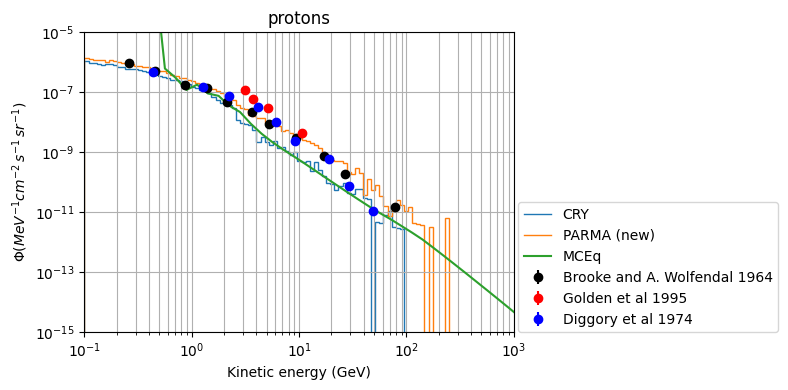

In [5]:
bins = np.logspace(np.log10(0.1), np.log10(600), 100)
binwidth = (bins[1:]-bins[:-1]) * 1000 # Turn to MeV

angle_cut_rad = 0.1
angle_sterad = 2*np.pi*(1-np.cos(angle_cut_rad/2))

plt.figure(figsize=(8,4))

# Line 1
cry_area = (10*100)**2
cry_norm = 5741*cry_area*angle_sterad
x = data_cry["ekin"]
mask = np.abs(data_cry["zenith_angle"])<angle_cut_rad
n1, ibins = np.histogram(x[mask], bins=bins, weights=np.ones(sum(mask))/cry_norm)
plt.stairs(n1/binwidth, ibins, label="CRY")
print(sum(mask))

# Line 2
parma_norm = len(data_parma["ekin"])/0.000363366 * angle_sterad
x = data_parma["ekin"]
mask = np.abs(data_parma["zenith_angle"])<angle_cut_rad
n2, ibins = np.histogram(x[mask], bins=bins, weights=np.ones(sum(mask))/parma_norm)
plt.stairs(n2/binwidth, ibins, label="PARMA (new)")
print(sum(mask))


# Line 3
plt.loglog(mceq.e_grid, proton_flux*1e-3 * 2*np.pi, label='MCEq')




# Measurements
plt.errorbar(p2k(p_meas_mom), p_meas_int * 2*np.pi, yerr=p_meas_unc, fmt="o", color="k", label="Brooke and A. Wolfendal 1964")

plt.errorbar(golden_1995_energy, golden_1995_int * 2*np.pi, yerr=golden_1995_unc, fmt="o", color="r", label="Golden et al 1995")

plt.errorbar(p2k(diggory_1974_momentum), diggory_1974_int * 2*np.pi, yerr=diggory_1974_unc, fmt="o", color="b", label="Diggory et al 1974")




plt.grid(which="both")
plt.xscale("log")
plt.yscale("log")
plt.legend(loc=(1.01,0))

plt.xlim(0.1,1000)
plt.ylim(1e-15, 1e-5)
plt.xlabel('Kinetic energy (GeV)')
plt.ylabel(r'$\Phi (MeV^{-1} cm^{-2} \, s^{-1} \, sr^{-1}$)')
plt.title("protons")
plt.tight_layout()
plt.savefig("fig_protons.png")
plt.show()

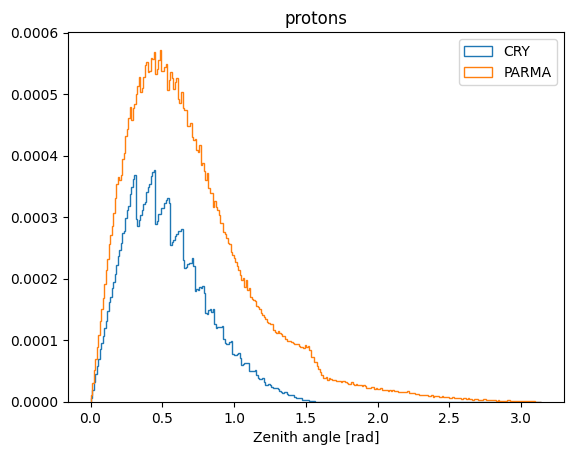

In [6]:
bins=np.linspace(0,np.pi,300)
plt.hist(data_cry["zenith_angle"], bins=bins,histtype="step", label="CRY", weights=np.ones(len(data_cry["zenith_angle"]))/cry_norm)
plt.hist(data_parma["zenith_angle"], bins=bins,histtype="step", label="PARMA", weights=np.ones(len(data_parma["zenith_angle"]))/parma_norm)
plt.xlabel("Zenith angle [rad]")
plt.legend()
plt.title("protons")
plt.savefig("fig_proton_angle.png")


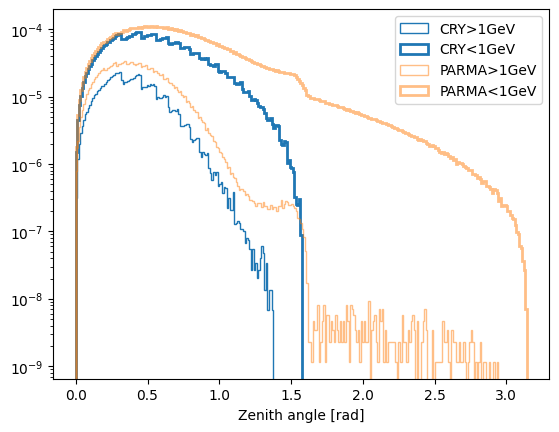

In [29]:

mask_he = data_cry["ekin"]>1
bins=np.linspace(0,np.pi,300)
plt.hist(data_cry["zenith_angle"][mask_he], bins=bins,histtype="step", label="CRY>1GeV", weights=np.ones(sum(mask_he))/cry_norm, color="C0")
plt.hist(data_cry["zenith_angle"][~mask_he], bins=bins,histtype="step", label="CRY<1GeV",  weights=np.ones(sum(~mask_he))/cry_norm, color="C0", linewidth=2)

mask_he = data_parma["ekin"]>1
bins=np.linspace(0,np.pi,300)
plt.hist(data_parma["zenith_angle"][mask_he], bins=bins,histtype="step", label="PARMA>1GeV", weights=np.ones(sum(mask_he))/parma_norm, color="C1", alpha=0.5)
plt.hist(data_parma["zenith_angle"][~mask_he], bins=bins,histtype="step", label="PARMA<1GeV", weights=np.ones(sum(~mask_he))/parma_norm, color="C1", linewidth=2, alpha=0.5)




plt.yscale("log")
plt.xlabel("Zenith angle [rad]")
plt.legend()